In [89]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import umap
from jupyterlab.semver import test_set
from setuptools.command.rotate import rotate
from sklearn.ensemble import RandomForestClassifier

from sarcasm_classifier.utils.tools import connect_data_dirs
from configs.manager import ConfigManager
# from sklearn.feature_selection import

In [90]:
cm = ConfigManager('model-training').config

In [91]:
def load_train(val=True, keep_only_embeddings = False):
    train_files_path = f"../{cm.train_files_path}" # To remove in prod!!!!!
    train_set = pd.read_csv(connect_data_dirs(train_files_path, 'train.csv'))
    test_set = pd.read_csv(connect_data_dirs(train_files_path, 'test.csv'))
    validation_set = pd.DataFrame()

    if val:
        validation_set = pd.read_csv(connect_data_dirs(train_files_path, 'validation.csv'))

    if keep_only_embeddings:
        train_set.drop(['punctuations','repeated_punctuations'], axis=1, inplace=True)
        test_set.drop(['punctuations','repeated_punctuations'], axis=1, inplace=True)
        try:
            validation_set.drop(['punctuations','repeated_punctuations'], axis=1, inplace=True)
        except:
            pass

    return train_set, test_set, validation_set

In [92]:
X, Y, Z = load_train(val=True, keep_only_embeddings=False)
print(X.shape, Y.shape, Z.shape)
# X, Y, Z_empty = load_train(False)
# print(X.shape, Y.shape, Z_empty.shape)

(6757, 773) (751, 773) (1878, 773)


In [93]:
def label_encode(df: pd.DataFrame, target_col: str = 'label', subclass_col: str = 'subClass'):
    label_renaming_map = {'sarc': 1, 'notsarc': 0}
    subclass_renaming_mape = {'gen':0,'hyp':1,'rq':2}
    df.replace(
        {
            target_col: label_renaming_map,
            subclass_col: subclass_renaming_mape
         },
        inplace=True
    )
    return df


In [94]:
X = label_encode(X, target_col='label', subclass_col='subClass')
Y = label_encode(Y, target_col='label', subclass_col='subClass')
Z = label_encode(Z, target_col='label', subclass_col='subClass')

X.label.unique(),Y.label.unique(), X.subClass.unique(),Y.subClass.unique()

/var/folders/mc/0frn8w7n5l3gnblclbskf6cc0000gp/T/ipykernel_42982/1228152953.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(


(array([1, 0]), array([1, 0]), array([0, 2, 1]), array([0, 2, 1]))

In [95]:
def prepare_training_sets(train_set, test_set, validation_set=None):
    to_drop = ['subClass', 'text', 'label']
    X_train = train_set.drop(to_drop, axis=1)
    y_train = train_set['label']
    ytrain_sc = train_set['subClass']
    X_test = test_set.drop(to_drop, axis=1)
    y_test = test_set['label']
    ytest_sc = test_set['subClass']
    if not validation_set.empty:
        X_val = validation_set.drop(to_drop, axis=1)
        y_val = validation_set['label']
        yval_sc = validation_set['subClass']
        return (X_train, y_train, ytrain_sc), (X_test, y_test, ytest_sc), (X_val, y_val, yval_sc)
    return (X_train, y_train, ytrain_sc), (X_test, y_test, ytest_sc), (pd.DataFrame(), [])


In [96]:
training_set, testing_set, validation_set = prepare_training_sets(X, Y, Z)

Classification 1: Sarcasm

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

lr = LogisticRegression(max_iter=1000)

lr.fit(X=training_set[0], y=training_set[1])
predictions = lr.predict(X=validation_set[0])

print(f'Naive approach: Logistic Regression accuracy: {accuracy_score(predictions, validation_set[1])}')

print(
    classification_report(
        predictions, validation_set[1]
    )
)

print(confusion_matrix(
    predictions, validation_set[1]
))

Naive approach: Logistic Regression accuracy: 0.7614483493077743
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       989
           1       0.74      0.76      0.75       889

    accuracy                           0.76      1878
   macro avg       0.76      0.76      0.76      1878
weighted avg       0.76      0.76      0.76      1878

[[758 231]
 [217 672]]


In [100]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(9)

knn.fit(X=training_set[0], y=training_set[1])
predictions = knn.predict(X=validation_set[0])

print(f'Naive approach: KNN accuracy: {accuracy_score(predictions, validation_set[1])}')

print(
    classification_report(
        predictions, validation_set[1]
    )
)

print(confusion_matrix(
    predictions, validation_set[1]
))

Naive approach: KNN accuracy: 0.6640042598509052
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       958
           1       0.66      0.65      0.65       920

    accuracy                           0.66      1878
   macro avg       0.66      0.66      0.66      1878
weighted avg       0.66      0.66      0.66      1878

[[651 307]
 [324 596]]


In [101]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=150, max_depth=6)

rfc.fit(X=training_set[0], y=training_set[1])
predictions = rfc.predict(X=validation_set[0])

print(f'Naive approach: RandomForrest accuracy: {accuracy_score(predictions, validation_set[1])}')

print(
    classification_report(
        predictions, validation_set[1]
    )
)

print(confusion_matrix(
    predictions, validation_set[1]
))

Naive approach: RandomForrest accuracy: 0.7470713525026624
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       950
           1       0.75      0.73      0.74       928

    accuracy                           0.75      1878
   macro avg       0.75      0.75      0.75      1878
weighted avg       0.75      0.75      0.75      1878

[[725 225]
 [250 678]]


In [102]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from typing import Tuple

def tune_xgboost_with_optuna(training_object: Tuple[Tuple, Tuple, Tuple], 
                           target_type: str = 'sarcasm', 
                           n_trials: int = 100,
                           random_state: int = 42) -> dict:
    """
    Hyperparameter tuning for XGBoost using Optuna optimization.
    
    Parameters:
    -----------
    training_object : tuple
        A tuple containing (train_set, test_set, validation_set) where each set is 
        a tuple of (X, y, y_subclass)
    target_type : str, default 'sarcasm'
        'sarcasm' for binary classification or 'subclass' for multiclass classification
    n_trials : int, default 100
        Number of optimization trials to run
    random_state : int, default 42
        Random state for reproducibility
        
    Returns:
    --------
    dict : Dictionary containing best parameters, best score, and trained model
    """
    
    train_set, test_set, validation_set = training_object
    X_train, y_train, y_train_sc = train_set
    X_val, y_val, y_val_sc = validation_set
    
    # Select target based on classification type
    if target_type == 'sarcasm':
        y_train_target = y_train
        y_val_target = y_val
        num_classes = 2
    elif target_type == 'subclass':
        y_train_target = y_train_sc
        y_val_target = y_val_sc
        num_classes = len(y_train_sc.unique())
    else:
        raise ValueError("target_type must be 'sarcasm' or 'subclass'")
    
    def objective(trial):
        # Suggest hyperparameters
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'random_state': random_state,
            'verbosity': 0
        }
        
        # For multiclass classification
        if num_classes > 2:
            params['objective'] = 'multi:softmax'
            params['num_class'] = num_classes
            params['eval_metric'] = 'mlogloss'
        else:
            params['objective'] = 'binary:logistic'
            params['eval_metric'] = 'logloss'
        
        # Create and train model
        model = XGBClassifier(**params)
        model.fit(X_train, y_train_target, 
                 eval_set=[(X_val, y_val_target)], 
                 verbose=False)
        
        # Make predictions and calculate score
        y_pred = model.predict(X_val)
        
        # Use F1-score for optimization (macro average for multiclass)
        if num_classes > 2:
            score = f1_score(y_val_target, y_pred, average='macro')
        else:
            score = f1_score(y_val_target, y_pred)
            
        return score
    
    # Create study and optimize
    study = optuna.create_study(direction='maximize', 
                               sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Train final model with best parameters
    best_params = study.best_params
    best_params.update({
        'random_state': random_state,
        'verbosity': 0
    })
    
    if num_classes > 2:
        best_params['objective'] = 'multi:softmax'
        best_params['num_class'] = num_classes
        best_params['eval_metric'] = 'mlogloss'
    else:
        best_params['objective'] = 'binary:logistic'
        best_params['eval_metric'] = 'logloss'
    
    final_model = XGBClassifier(**best_params)
    final_model.fit(X_train, y_train_target)
    
    # Calculate final scores
    train_pred = final_model.predict(X_train)
    val_pred = final_model.predict(X_val)
    
    if num_classes > 2:
        train_f1 = f1_score(y_train_target, train_pred, average='macro')
        val_f1 = f1_score(y_val_target, val_pred, average='macro')
    else:
        train_f1 = f1_score(y_train_target, train_pred)
        val_f1 = f1_score(y_val_target, val_pred)
    
    train_acc = accuracy_score(y_train_target, train_pred)
    val_acc = accuracy_score(y_val_target, val_pred)
    
    return {
        'best_params': best_params,
        'best_f1_score': study.best_value,
        'model': final_model,
        'train_accuracy': train_acc,
        'validation_accuracy': val_acc,
        'train_f1': train_f1,
        'validation_f1': val_f1,
        'study': study
    }

In [103]:
# Example usage of the Optuna hyperparameter tuning function

# Test with sarcasm classification (binary)
print("Starting hyperparameter tuning for sarcasm classification...")
sarcasm_results = tune_xgboost_with_optuna(
    training_object=(training_set, testing_set, validation_set),
    target_type='sarcasm',
    n_trials=20,  # Reduced for quick testing
    random_state=42
)

print(f"\nSarcasm Classification Results:")
print(f"Best F1 Score: {sarcasm_results['best_f1_score']:.4f}")
print(f"Validation Accuracy: {sarcasm_results['validation_accuracy']:.4f}")
print(f"Validation F1: {sarcasm_results['validation_f1']:.4f}")
print(f"Best Parameters: {sarcasm_results['best_params']}")

[I 2025-11-18 09:32:25,319] A new study created in memory with name: no-name-5c481e06-cda5-4724-b3ef-6e12af1687e3


Starting hyperparameter tuning for sarcasm classification...


Best trial: 0. Best value: 0.749584:   5%|▌         | 1/20 [00:05<01:53,  5.98s/it]

[I 2025-11-18 09:32:31,296] Trial 0 finished with value: 0.7495835646862854 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 2.5348407664333426e-07, 'reg_lambda': 3.3323645788192616e-08, 'min_child_weight': 9}. Best is trial 0 with value: 0.7495835646862854.


Best trial: 1. Best value: 0.761695:  10%|█         | 2/20 [00:49<08:24, 28.02s/it]

[I 2025-11-18 09:33:14,743] Trial 1 finished with value: 0.7616951018161805 and parameters: {'n_estimators': 321, 'max_depth': 12, 'learning_rate': 0.010725209743171997, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'reg_alpha': 8.148018307012941e-07, 'reg_lambda': 4.329370014459266e-07, 'min_child_weight': 2}. Best is trial 1 with value: 0.7616951018161805.


Best trial: 2. Best value: 0.762486:  15%|█▌        | 3/20 [00:57<05:23, 19.05s/it]

[I 2025-11-18 09:33:23,132] Trial 2 finished with value: 0.7624861265260822 and parameters: {'n_estimators': 187, 'max_depth': 9, 'learning_rate': 0.04345454109729477, 'subsample': 0.645614570099021, 'colsample_bytree': 0.8059264473611898, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'min_child_weight': 4}. Best is trial 2 with value: 0.7624861265260822.


Best trial: 2. Best value: 0.762486:  20%|██        | 4/20 [01:23<05:44, 21.55s/it]

[I 2025-11-18 09:33:48,507] Trial 3 finished with value: 0.7609055770292656 and parameters: {'n_estimators': 255, 'max_depth': 13, 'learning_rate': 0.019721610970574007, 'subsample': 0.7571172192068059, 'colsample_bytree': 0.7962072844310213, 'reg_alpha': 2.6185068507773707e-08, 'reg_lambda': 0.0029369981104377003, 'min_child_weight': 2}. Best is trial 2 with value: 0.7624861265260822.


Best trial: 2. Best value: 0.762486:  25%|██▌       | 5/20 [01:26<03:43, 14.91s/it]

[I 2025-11-18 09:33:51,640] Trial 4 finished with value: 0.737885462555066 and parameters: {'n_estimators': 79, 'max_depth': 15, 'learning_rate': 0.26690431824362526, 'subsample': 0.9041986740582306, 'colsample_bytree': 0.6523068845866853, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.01439120761572808, 'min_child_weight': 5}. Best is trial 2 with value: 0.7624861265260822.


Best trial: 2. Best value: 0.762486:  30%|███       | 6/20 [01:32<02:45, 11.84s/it]

[I 2025-11-18 09:33:57,523] Trial 5 finished with value: 0.7390350877192983 and parameters: {'n_estimators': 105, 'max_depth': 9, 'learning_rate': 0.011240768803005551, 'subsample': 0.954660201039391, 'colsample_bytree': 0.6293899908000085, 'reg_alpha': 0.009176996354542699, 'reg_lambda': 6.388511557344611e-06, 'min_child_weight': 6}. Best is trial 2 with value: 0.7624861265260822.


Best trial: 2. Best value: 0.762486:  35%|███▌      | 7/20 [01:36<02:03,  9.50s/it]

[I 2025-11-18 09:34:02,209] Trial 6 finished with value: 0.7530054644808744 and parameters: {'n_estimators': 296, 'max_depth': 5, 'learning_rate': 0.2705166881899928, 'subsample': 0.8875664116805573, 'colsample_bytree': 0.9697494707820946, 'reg_alpha': 1.1309571585271492, 'reg_lambda': 0.002404915432737351, 'min_child_weight': 10}. Best is trial 2 with value: 0.7624861265260822.


Best trial: 2. Best value: 0.762486:  40%|████      | 8/20 [01:38<01:24,  7.05s/it]

[I 2025-11-18 09:34:04,005] Trial 7 finished with value: 0.7346938775510204 and parameters: {'n_estimators': 89, 'max_depth': 5, 'learning_rate': 0.011662890273931383, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.287499823474079, 'min_child_weight': 4}. Best is trial 2 with value: 0.7624861265260822.


Best trial: 2. Best value: 0.762486:  45%|████▌     | 9/20 [01:49<01:30,  8.22s/it]

[I 2025-11-18 09:34:14,790] Trial 8 finished with value: 0.7512355848434926 and parameters: {'n_estimators': 176, 'max_depth': 10, 'learning_rate': 0.016149614799999188, 'subsample': 0.9010984903770198, 'colsample_bytree': 0.5372753218398854, 'reg_alpha': 7.6204817861585425, 'reg_lambda': 0.08916674715636552, 'min_child_weight': 2}. Best is trial 2 with value: 0.7624861265260822.


Best trial: 2. Best value: 0.762486:  50%|█████     | 10/20 [01:55<01:14,  7.48s/it]

[I 2025-11-18 09:34:20,615] Trial 9 finished with value: 0.7556287753981329 and parameters: {'n_estimators': 52, 'max_depth': 13, 'learning_rate': 0.11069143219393454, 'subsample': 0.8645035840204937, 'colsample_bytree': 0.8856351733429728, 'reg_alpha': 4.638759594322625e-08, 'reg_lambda': 1.683416412018213e-05, 'min_child_weight': 2}. Best is trial 2 with value: 0.7624861265260822.


Best trial: 10. Best value: 0.764641:  55%|█████▌    | 11/20 [02:06<01:17,  8.57s/it]

[I 2025-11-18 09:34:31,646] Trial 10 finished with value: 0.7646408839779005 and parameters: {'n_estimators': 440, 'max_depth': 7, 'learning_rate': 0.03504750508385013, 'subsample': 0.5089809378074098, 'colsample_bytree': 0.7846562513261506, 'reg_alpha': 9.72116179047762e-05, 'reg_lambda': 4.3444691085504035, 'min_child_weight': 7}. Best is trial 10 with value: 0.7646408839779005.


Best trial: 11. Best value: 0.765487:  60%|██████    | 12/20 [02:18<01:16,  9.55s/it]

[I 2025-11-18 09:34:43,446] Trial 11 finished with value: 0.7654867256637168 and parameters: {'n_estimators': 477, 'max_depth': 7, 'learning_rate': 0.035290106990621815, 'subsample': 0.5051915649537512, 'colsample_bytree': 0.7930679183446125, 'reg_alpha': 8.113466471626533e-05, 'reg_lambda': 4.188416507348492, 'min_child_weight': 7}. Best is trial 11 with value: 0.7654867256637168.


Best trial: 11. Best value: 0.765487:  65%|██████▌   | 13/20 [02:29<01:11, 10.18s/it]

[I 2025-11-18 09:34:55,076] Trial 12 finished with value: 0.7641196013289037 and parameters: {'n_estimators': 488, 'max_depth': 7, 'learning_rate': 0.0391334743391237, 'subsample': 0.5017806615504058, 'colsample_bytree': 0.7447014489005495, 'reg_alpha': 0.00018660551793947024, 'reg_lambda': 8.964592852736423, 'min_child_weight': 7}. Best is trial 11 with value: 0.7654867256637168.


Best trial: 11. Best value: 0.765487:  70%|███████   | 14/20 [02:34<00:51,  8.59s/it]

[I 2025-11-18 09:34:59,982] Trial 13 finished with value: 0.7602012297372834 and parameters: {'n_estimators': 496, 'max_depth': 3, 'learning_rate': 0.028038541728296652, 'subsample': 0.5049623702934061, 'colsample_bytree': 0.8255079015857973, 'reg_alpha': 8.557191342184109e-05, 'reg_lambda': 9.868745464853797, 'min_child_weight': 8}. Best is trial 11 with value: 0.7654867256637168.


Best trial: 14. Best value: 0.768205:  75%|███████▌  | 15/20 [02:44<00:44,  8.94s/it]

[I 2025-11-18 09:35:09,753] Trial 14 finished with value: 0.7682045580878266 and parameters: {'n_estimators': 406, 'max_depth': 7, 'learning_rate': 0.0717288467604553, 'subsample': 0.5797654491534234, 'colsample_bytree': 0.7226065972922637, 'reg_alpha': 0.004720176210197528, 'reg_lambda': 0.48655210851246566, 'min_child_weight': 7}. Best is trial 14 with value: 0.7682045580878266.


Best trial: 14. Best value: 0.768205:  80%|████████  | 16/20 [02:52<00:35,  8.78s/it]

[I 2025-11-18 09:35:18,152] Trial 15 finished with value: 0.7679558011049724 and parameters: {'n_estimators': 390, 'max_depth': 7, 'learning_rate': 0.07535095957849387, 'subsample': 0.602468083308022, 'colsample_bytree': 0.7261631564388042, 'reg_alpha': 0.00958432957075115, 'reg_lambda': 0.39368146336629317, 'min_child_weight': 8}. Best is trial 14 with value: 0.7682045580878266.


Best trial: 14. Best value: 0.768205:  85%|████████▌ | 17/20 [02:58<00:23,  7.78s/it]

[I 2025-11-18 09:35:23,614] Trial 16 finished with value: 0.7571743929359823 and parameters: {'n_estimators': 401, 'max_depth': 5, 'learning_rate': 0.07816969219263262, 'subsample': 0.6153015606233286, 'colsample_bytree': 0.6867229733335528, 'reg_alpha': 0.01706358855791761, 'reg_lambda': 0.27376832646227434, 'min_child_weight': 9}. Best is trial 14 with value: 0.7682045580878266.


Best trial: 14. Best value: 0.768205:  90%|█████████ | 18/20 [03:01<00:12,  6.39s/it]

[I 2025-11-18 09:35:26,760] Trial 17 finished with value: 0.7553600879604178 and parameters: {'n_estimators': 371, 'max_depth': 3, 'learning_rate': 0.0677485020437437, 'subsample': 0.5862877000340451, 'colsample_bytree': 0.7331103487182209, 'reg_alpha': 0.023160626719843612, 'reg_lambda': 9.458104969203116e-05, 'min_child_weight': 10}. Best is trial 14 with value: 0.7682045580878266.


Best trial: 14. Best value: 0.768205:  95%|█████████▌| 19/20 [03:09<00:06,  6.91s/it]

[I 2025-11-18 09:35:34,897] Trial 18 finished with value: 0.7541713014460512 and parameters: {'n_estimators': 399, 'max_depth': 11, 'learning_rate': 0.1564834442923059, 'subsample': 0.7125674867791649, 'colsample_bytree': 0.8664768927573612, 'reg_alpha': 0.0022222190346354947, 'reg_lambda': 0.011114390371567842, 'min_child_weight': 8}. Best is trial 14 with value: 0.7682045580878266.


Best trial: 14. Best value: 0.768205: 100%|██████████| 20/20 [03:18<00:00,  9.90s/it]


[I 2025-11-18 09:35:43,346] Trial 19 finished with value: 0.7625344352617079 and parameters: {'n_estimators': 328, 'max_depth': 8, 'learning_rate': 0.06289842758961865, 'subsample': 0.5737939719240995, 'colsample_bytree': 0.5989895328128745, 'reg_alpha': 0.18801239761453004, 'reg_lambda': 0.0003879077420079029, 'min_child_weight': 5}. Best is trial 14 with value: 0.7682045580878266.

Sarcasm Classification Results:
Best F1 Score: 0.7682
Validation Accuracy: 0.7780
Validation F1: 0.7682
Best Parameters: {'n_estimators': 406, 'max_depth': 7, 'learning_rate': 0.0717288467604553, 'subsample': 0.5797654491534234, 'colsample_bytree': 0.7226065972922637, 'reg_alpha': 0.004720176210197528, 'reg_lambda': 0.48655210851246566, 'min_child_weight': 7, 'random_state': 42, 'verbosity': 0, 'objective': 'binary:logistic', 'eval_metric': 'logloss'}


In [105]:
from sklearn.ensemble import RandomForestClassifier

def tune_randomforest_with_optuna(training_object: Tuple[Tuple, Tuple, Tuple], 
                                target_type: str = 'sarcasm', 
                                n_trials: int = 100,
                                random_state: int = 42) -> dict:
    """
    Hyperparameter tuning for Random Forest using Optuna optimization.
    
    Parameters:
    -----------
    training_object : tuple
        A tuple containing (train_set, test_set, validation_set) where each set is 
        a tuple of (X, y, y_subclass)
    target_type : str, default 'sarcasm'
        'sarcasm' for binary classification or 'subclass' for multiclass classification
    n_trials : int, default 100
        Number of optimization trials to run
    random_state : int, default 42
        Random state for reproducibility
        
    Returns:
    --------
    dict : Dictionary containing best parameters, best score, and trained model
    """
    
    train_set, test_set, validation_set = training_object
    X_train, y_train, y_train_sc = train_set
    X_val, y_val, y_val_sc = validation_set
    
    # Select target based on classification type
    if target_type == 'sarcasm':
        y_train_target = y_train
        y_val_target = y_val
        num_classes = 2
    elif target_type == 'subclass':
        y_train_target = y_train_sc
        y_val_target = y_val_sc
        num_classes = len(y_train_sc.unique())
    else:
        raise ValueError("target_type must be 'sarcasm' or 'subclass'")
    
    def objective(trial):
        # Suggest hyperparameters
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'random_state': random_state,
            'n_jobs': -1
        }
        
        # Add max_samples only if bootstrap is True
        if params['bootstrap']:
            params['max_samples'] = trial.suggest_float('max_samples', 0.5, 1.0)
        
        # Create and train model
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train_target)
        
        # Make predictions and calculate score
        y_pred = model.predict(X_val)
        
        # Use F1-score for optimization (macro average for multiclass)
        if num_classes > 2:
            score = f1_score(y_val_target, y_pred, average='macro')
        else:
            score = f1_score(y_val_target, y_pred)
            
        return score
    
    # Create study and optimize
    study = optuna.create_study(direction='maximize', 
                               sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Train final model with best parameters
    best_params = study.best_params
    best_params.update({
        'random_state': random_state,
        'n_jobs': -1
    })
    
    final_model = RandomForestClassifier(**best_params)
    final_model.fit(X_train, y_train_target)
    
    # Calculate final scores
    train_pred = final_model.predict(X_train)
    val_pred = final_model.predict(X_val)
    
    if num_classes > 2:
        train_f1 = f1_score(y_train_target, train_pred, average='macro')
        val_f1 = f1_score(y_val_target, val_pred, average='macro')
    else:
        train_f1 = f1_score(y_train_target, train_pred)
        val_f1 = f1_score(y_val_target, val_pred)
    
    train_acc = accuracy_score(y_train_target, train_pred)
    val_acc = accuracy_score(y_val_target, val_pred)
    
    return {
        'best_params': best_params,
        'best_f1_score': study.best_value,
        'model': final_model,
        'train_accuracy': train_acc,
        'validation_accuracy': val_acc,
        'train_f1': train_f1,
        'validation_f1': val_f1,
        'study': study
    }

In [106]:
# Example usage of the Random Forest Optuna hyperparameter tuning function

# Test with sarcasm classification (binary)
print("Starting Random Forest hyperparameter tuning for sarcasm classification...")
rf_sarcasm_results = tune_randomforest_with_optuna(
    training_object=(training_set, testing_set, validation_set),
    target_type='sarcasm',
    n_trials=20,  # Reduced for quick testing
    random_state=42
)

print(f"\nRandom Forest Sarcasm Classification Results:")
print(f"Best F1 Score: {rf_sarcasm_results['best_f1_score']:.4f}")
print(f"Validation Accuracy: {rf_sarcasm_results['validation_accuracy']:.4f}")
print(f"Validation F1: {rf_sarcasm_results['validation_f1']:.4f}")
print(f"Best Parameters: {rf_sarcasm_results['best_params']}")

# Test with subclass classification (multiclass)  
print("\n" + "="*50)
print("Starting Random Forest hyperparameter tuning for subclass classification...")
rf_subclass_results = tune_randomforest_with_optuna(
    training_object=(training_set, testing_set, validation_set),
    target_type='subclass', 
    n_trials=20,  # Reduced for quick testing
    random_state=42
)

print(f"\nRandom Forest Subclass Classification Results:")
print(f"Best F1 Score: {rf_subclass_results['best_f1_score']:.4f}")
print(f"Validation Accuracy: {rf_subclass_results['validation_accuracy']:.4f}")  
print(f"Validation F1: {rf_subclass_results['validation_f1']:.4f}")
print(f"Best Parameters: {rf_subclass_results['best_params']}")

[I 2025-11-18 09:50:30,199] A new study created in memory with name: no-name-030ad2bd-6909-4fb0-b161-582d939c60ce


Starting Random Forest hyperparameter tuning for sarcasm classification...


Best trial: 0. Best value: 0.751092:   5%|▌         | 1/20 [00:03<01:09,  3.68s/it]

[I 2025-11-18 09:50:33,881] Trial 0 finished with value: 0.7510917030567685 and parameters: {'n_estimators': 218, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.8540362888980227}. Best is trial 0 with value: 0.7510917030567685.


Best trial: 0. Best value: 0.751092:  10%|█         | 2/20 [00:32<05:27, 18.21s/it]

[I 2025-11-18 09:51:02,253] Trial 1 finished with value: 0.7471074380165289 and parameters: {'n_estimators': 59, 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'max_samples': 0.645614570099021}. Best is trial 0 with value: 0.7510917030567685.


Best trial: 0. Best value: 0.751092:  15%|█▌        | 3/20 [00:34<03:09, 11.14s/it]

[I 2025-11-18 09:51:04,985] Trial 2 finished with value: 0.7443365695792881 and parameters: {'n_estimators': 325, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.7510917030567685.


Best trial: 0. Best value: 0.751092:  20%|██        | 4/20 [00:35<01:50,  6.94s/it]

[I 2025-11-18 09:51:05,477] Trial 3 finished with value: 0.7386117136659436 and parameters: {'n_estimators': 70, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'max_samples': 0.8421165132560784}. Best is trial 0 with value: 0.7510917030567685.


Best trial: 0. Best value: 0.751092:  25%|██▌       | 5/20 [00:40<01:34,  6.30s/it]

[I 2025-11-18 09:51:10,638] Trial 4 finished with value: 0.747949699289229 and parameters: {'n_estimators': 248, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.7510917030567685.


Best trial: 0. Best value: 0.751092:  30%|███       | 6/20 [00:43<01:12,  5.20s/it]

[I 2025-11-18 09:51:13,699] Trial 5 finished with value: 0.7474086197490453 and parameters: {'n_estimators': 296, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.5979914312095727}. Best is trial 0 with value: 0.7510917030567685.


Best trial: 0. Best value: 0.751092:  35%|███▌      | 7/20 [00:44<00:50,  3.91s/it]

[I 2025-11-18 09:51:14,963] Trial 6 finished with value: 0.7416216216216216 and parameters: {'n_estimators': 70, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.9010984903770198}. Best is trial 0 with value: 0.7510917030567685.


Best trial: 7. Best value: 0.751236:  40%|████      | 8/20 [00:45<00:35,  2.95s/it]

[I 2025-11-18 09:51:15,860] Trial 7 finished with value: 0.7512355848434926 and parameters: {'n_estimators': 83, 'max_depth': 30, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 7 with value: 0.7512355848434926.


Best trial: 7. Best value: 0.751236:  45%|████▌     | 9/20 [00:47<00:29,  2.72s/it]

[I 2025-11-18 09:51:18,067] Trial 8 finished with value: 0.7427635172037138 and parameters: {'n_estimators': 83, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 7 with value: 0.7512355848434926.


Best trial: 7. Best value: 0.751236:  50%|█████     | 10/20 [05:51<15:55, 95.59s/it]

[I 2025-11-18 09:56:21,611] Trial 9 finished with value: 0.6297731045932484 and parameters: {'n_estimators': 379, 'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': False}. Best is trial 7 with value: 0.7512355848434926.


Best trial: 7. Best value: 0.751236:  55%|█████▌    | 11/20 [05:55<10:09, 67.71s/it]

[I 2025-11-18 09:56:26,101] Trial 10 finished with value: 0.7506819421713039 and parameters: {'n_estimators': 476, 'max_depth': 25, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 7 with value: 0.7512355848434926.


Best trial: 7. Best value: 0.751236:  60%|██████    | 12/20 [05:57<06:19, 47.46s/it]

[I 2025-11-18 09:56:27,258] Trial 11 finished with value: 0.7427949972811311 and parameters: {'n_estimators': 182, 'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True, 'max_samples': 0.957818985389437}. Best is trial 7 with value: 0.7512355848434926.


Best trial: 7. Best value: 0.751236:  65%|██████▌   | 13/20 [05:59<03:56, 33.75s/it]

[I 2025-11-18 09:56:29,458] Trial 12 finished with value: 0.7410228509249184 and parameters: {'n_estimators': 171, 'max_depth': 25, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.7590795828321593}. Best is trial 7 with value: 0.7512355848434926.


Best trial: 13. Best value: 0.759036:  70%|███████   | 14/20 [06:01<02:24, 24.09s/it]

[I 2025-11-18 09:56:31,239] Trial 13 finished with value: 0.7590361445783133 and parameters: {'n_estimators': 176, 'max_depth': 26, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 13 with value: 0.7590361445783133.


Best trial: 13. Best value: 0.759036:  75%|███████▌  | 15/20 [06:02<01:26, 17.32s/it]

[I 2025-11-18 09:56:32,875] Trial 14 finished with value: 0.7487575924903368 and parameters: {'n_estimators': 143, 'max_depth': 23, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 13 with value: 0.7590361445783133.


Best trial: 13. Best value: 0.759036:  80%|████████  | 16/20 [06:03<00:50, 12.50s/it]

[I 2025-11-18 09:56:34,180] Trial 15 finished with value: 0.7505518763796909 and parameters: {'n_estimators': 127, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 13 with value: 0.7590361445783133.


Best trial: 13. Best value: 0.759036:  85%|████████▌ | 17/20 [06:06<00:28,  9.36s/it]

[I 2025-11-18 09:56:36,244] Trial 16 finished with value: 0.7501366867140514 and parameters: {'n_estimators': 220, 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 13 with value: 0.7590361445783133.


Best trial: 13. Best value: 0.759036:  90%|█████████ | 18/20 [06:07<00:13,  6.91s/it]

[I 2025-11-18 09:56:37,437] Trial 17 finished with value: 0.749047359825803 and parameters: {'n_estimators': 115, 'max_depth': 27, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 13 with value: 0.7590361445783133.


Best trial: 13. Best value: 0.759036:  95%|█████████▌| 19/20 [08:52<00:54, 54.48s/it]

[I 2025-11-18 09:59:22,730] Trial 18 finished with value: 0.6373142542652724 and parameters: {'n_estimators': 170, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': False}. Best is trial 13 with value: 0.7590361445783133.


Best trial: 13. Best value: 0.759036: 100%|██████████| 20/20 [08:57<00:00, 26.90s/it]


[I 2025-11-18 09:59:28,163] Trial 19 finished with value: 0.7510869565217392 and parameters: {'n_estimators': 398, 'max_depth': 23, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False}. Best is trial 13 with value: 0.7590361445783133.


[I 2025-11-18 09:59:30,994] A new study created in memory with name: no-name-63c4aec2-e98f-4bd1-be4a-4831437dd39f



Random Forest Sarcasm Classification Results:
Best F1 Score: 0.7590
Validation Accuracy: 0.7657
Validation F1: 0.7590
Best Parameters: {'n_estimators': 176, 'max_depth': 26, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False, 'random_state': 42, 'n_jobs': -1}

Starting Random Forest hyperparameter tuning for subclass classification...


Best trial: 0. Best value: 0.273574:   5%|▌         | 1/20 [00:05<01:51,  5.86s/it]

[I 2025-11-18 09:59:36,855] Trial 0 finished with value: 0.27357404500261645 and parameters: {'n_estimators': 218, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.8540362888980227}. Best is trial 0 with value: 0.27357404500261645.


Best trial: 1. Best value: 0.3045:  10%|█         | 2/20 [00:48<08:19, 27.74s/it]  

[I 2025-11-18 10:00:19,916] Trial 1 finished with value: 0.30450000966912266 and parameters: {'n_estimators': 59, 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'max_samples': 0.645614570099021}. Best is trial 1 with value: 0.30450000966912266.


Best trial: 1. Best value: 0.3045:  15%|█▌        | 3/20 [00:52<04:43, 16.65s/it]

[I 2025-11-18 10:00:23,360] Trial 2 finished with value: 0.27517198248905567 and parameters: {'n_estimators': 325, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.30450000966912266.


Best trial: 1. Best value: 0.3045:  20%|██        | 4/20 [00:53<02:45, 10.33s/it]

[I 2025-11-18 10:00:24,012] Trial 3 finished with value: 0.2683651804670913 and parameters: {'n_estimators': 70, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'max_samples': 0.8421165132560784}. Best is trial 1 with value: 0.30450000966912266.


Best trial: 1. Best value: 0.3045:  25%|██▌       | 5/20 [01:00<02:21,  9.44s/it]

[I 2025-11-18 10:00:31,877] Trial 4 finished with value: 0.27504952559691376 and parameters: {'n_estimators': 248, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.30450000966912266.


Best trial: 1. Best value: 0.3045:  30%|███       | 6/20 [01:05<01:49,  7.83s/it]

[I 2025-11-18 10:00:36,577] Trial 5 finished with value: 0.27517198248905567 and parameters: {'n_estimators': 296, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.5979914312095727}. Best is trial 1 with value: 0.30450000966912266.


Best trial: 1. Best value: 0.3045:  35%|███▌      | 7/20 [01:07<01:15,  5.78s/it]

[I 2025-11-18 10:00:38,132] Trial 6 finished with value: 0.27787739743351136 and parameters: {'n_estimators': 70, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.9010984903770198}. Best is trial 1 with value: 0.30450000966912266.


Best trial: 1. Best value: 0.3045:  40%|████      | 8/20 [01:08<00:53,  4.48s/it]

[I 2025-11-18 10:00:39,819] Trial 7 finished with value: 0.26670930604413173 and parameters: {'n_estimators': 83, 'max_depth': 30, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.30450000966912266.


Best trial: 1. Best value: 0.3045:  45%|████▌     | 9/20 [01:11<00:43,  3.95s/it]

[I 2025-11-18 10:00:42,626] Trial 8 finished with value: 0.270635423263669 and parameters: {'n_estimators': 83, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.30450000966912266.


Best trial: 9. Best value: 0.36833:  50%|█████     | 10/20 [07:11<18:57, 113.75s/it]

[I 2025-11-18 10:06:42,226] Trial 9 finished with value: 0.3683304107885661 and parameters: {'n_estimators': 379, 'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': False}. Best is trial 9 with value: 0.3683304107885661.


Best trial: 10. Best value: 0.371641:  55%|█████▌    | 11/20 [14:30<32:00, 213.43s/it]

[I 2025-11-18 10:14:01,689] Trial 10 finished with value: 0.37164136747100235 and parameters: {'n_estimators': 487, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': False}. Best is trial 10 with value: 0.37164136747100235.


Best trial: 10. Best value: 0.371641:  60%|██████    | 12/20 [21:55<37:50, 283.85s/it]

[I 2025-11-18 10:21:26,591] Trial 11 finished with value: 0.37136016546956235 and parameters: {'n_estimators': 495, 'max_depth': 21, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': False}. Best is trial 10 with value: 0.37164136747100235.


Best trial: 10. Best value: 0.371641:  65%|██████▌   | 13/20 [29:25<38:58, 334.03s/it]

[I 2025-11-18 10:28:56,087] Trial 12 finished with value: 0.36577293308965614 and parameters: {'n_estimators': 489, 'max_depth': 23, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': False}. Best is trial 10 with value: 0.37164136747100235.


Best trial: 10. Best value: 0.371641:  70%|███████   | 14/20 [36:02<35:19, 353.19s/it]

[I 2025-11-18 10:35:33,535] Trial 13 finished with value: 0.36036052623672715 and parameters: {'n_estimators': 485, 'max_depth': 25, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': False}. Best is trial 10 with value: 0.37164136747100235.


Best trial: 10. Best value: 0.371641:  75%|███████▌  | 15/20 [41:29<28:46, 345.36s/it]

[I 2025-11-18 10:41:00,761] Trial 14 finished with value: 0.36334322574935846 and parameters: {'n_estimators': 398, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': False}. Best is trial 10 with value: 0.37164136747100235.


Best trial: 10. Best value: 0.371641:  80%|████████  | 16/20 [48:04<24:00, 360.22s/it]

[I 2025-11-18 10:47:35,497] Trial 15 finished with value: 0.36577293308965614 and parameters: {'n_estimators': 439, 'max_depth': 25, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': False}. Best is trial 10 with value: 0.37164136747100235.


Best trial: 10. Best value: 0.371641:  85%|████████▌ | 17/20 [50:33<14:50, 296.74s/it]

[I 2025-11-18 10:50:04,595] Trial 16 finished with value: 0.36926423776074274 and parameters: {'n_estimators': 182, 'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': False}. Best is trial 10 with value: 0.37164136747100235.


Best trial: 10. Best value: 0.371641:  90%|█████████ | 18/20 [56:41<10:36, 318.03s/it]

[I 2025-11-18 10:56:12,180] Trial 17 finished with value: 0.35815548551501547 and parameters: {'n_estimators': 430, 'max_depth': 26, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': False}. Best is trial 10 with value: 0.37164136747100235.


Best trial: 10. Best value: 0.371641:  95%|█████████▌| 19/20 [1:01:53<05:16, 316.37s/it]

[I 2025-11-18 11:01:24,679] Trial 18 finished with value: 0.36259032069146574 and parameters: {'n_estimators': 348, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': False}. Best is trial 10 with value: 0.37164136747100235.


Best trial: 10. Best value: 0.371641: 100%|██████████| 20/20 [1:07:19<00:00, 201.96s/it]


[I 2025-11-18 11:06:50,217] Trial 19 finished with value: 0.3622306171292511 and parameters: {'n_estimators': 443, 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': False}. Best is trial 10 with value: 0.37164136747100235.

Random Forest Subclass Classification Results:
Best F1 Score: 0.3716
Validation Accuracy: 0.5974
Validation F1: 0.3716
Best Parameters: {'n_estimators': 487, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': False, 'random_state': 42, 'n_jobs': -1}


In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np

class SimpleANN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.4):
        super(SimpleANN, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Create hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def train_pytorch_ann(training_object,
                     target_type: str = 'sarcasm',
                     hidden_sizes: list = None,
                     epochs: int = 50,
                     batch_size: int = 64,
                     learning_rate: float = 0.01,
                     dropout_rate: float = 0.2,
                     early_stopping_patience: int = 15,
                     scale_features: bool = True,
                     random_state: int = 42) -> dict:
    """
    Train a PyTorch Neural Network for classification.
    
    Parameters:
    -----------
    training_object : tuple
        A tuple containing (train_set, test_set, validation_set)
    target_type : str, default 'sarcasm'
        'sarcasm' for binary classification or 'subclass' for multiclass
    hidden_sizes : list, default None
        List of hidden layer sizes. If None, uses default architecture
    epochs : int, default 100
        Maximum number of training epochs
    batch_size : int, default 64
        Batch size for training
    learning_rate : float, default 0.001
        Learning rate for optimizer
    dropout_rate : float, default 0.2
        Dropout rate for regularization
    early_stopping_patience : int, default 15
        Patience for early stopping
    scale_features : bool, default True
        Whether to standardize features
    random_state : int, default 42
        Random state for reproducibility
        
    Returns:
    --------
    dict : Dictionary containing model, scaler, and performance metrics
    """
    
    # Set random seeds
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    
    train_set, test_set, validation_set = training_object
    X_train, y_train, y_train_sc = train_set
    X_val, y_val, y_val_sc = validation_set
    X_test, y_test, y_test_sc = test_set
    
    # Select target based on classification type
    if target_type == 'sarcasm':
        y_train_target = y_train
        y_val_target = y_val
        y_test_target = y_test
        num_classes = 2
    elif target_type == 'subclass':
        y_train_target = y_train_sc
        y_val_target = y_val_sc
        y_test_target = y_test_sc
        num_classes = 3
    else:
        raise ValueError("target_type must be 'sarcasm' or 'subclass'")
    
    # Scale features if requested
    scaler = None
    if scale_features:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train.values
        X_val_scaled = X_val.values
        X_test_scaled = X_test.values
    
    # Set default architecture if not provided
    input_size = X_train_scaled.shape[1]
    if hidden_sizes is None:
        if num_classes == 2:
            hidden_sizes = [128, 64]
        else:
            hidden_sizes = [256, 128, 64]
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train_target.values)

    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.LongTensor(y_val_target.values)

    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test_target.values)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, loss function, and optimizer
    model = SimpleANN(input_size, hidden_sizes, num_classes, dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    print(f"Training PyTorch ANN with architecture: {hidden_sizes}")
    print(f"Input features: {input_size}")
    print(f"Output classes: {num_classes}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
    
    # Training loop with early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
            val_losses.append(val_loss)
            
            # Calculate validation accuracy
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_accuracy = (val_predicted == y_val_tensor).sum().item() / len(y_val_tensor)
            val_accuracies.append(val_accuracy)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        # Train predictions
        train_outputs = model(X_train_tensor)
        _, train_predicted = torch.max(train_outputs.data, 1)
        
        # Validation predictions
        val_outputs = model(X_val_tensor)
        _, val_predicted = torch.max(val_outputs.data, 1)
        
        # Test predictions
        test_outputs = model(X_test_tensor)
        _, test_predicted = torch.max(test_outputs.data, 1)
    
    # Convert predictions back to numpy for sklearn metrics
    train_pred_np = train_predicted.numpy()
    val_pred_np = val_predicted.numpy()
    test_pred_np = test_predicted.numpy()
    
    # Calculate metrics
    if num_classes > 2:
        train_f1 = f1_score(y_train_target, train_pred_np, average='macro')
        val_f1 = f1_score(y_val_target, val_pred_np, average='macro')
        test_f1 = f1_score(y_test_target, test_pred_np, average='macro')
    else:
        train_f1 = f1_score(y_train_target, train_pred_np)
        val_f1 = f1_score(y_val_target, val_pred_np)
        test_f1 = f1_score(y_test_target, test_pred_np)
    
    train_acc = accuracy_score(y_train_target, train_pred_np)
    val_acc = accuracy_score(y_val_target, val_pred_np)
    test_acc = accuracy_score(y_test_target, test_pred_np)
    
    return {
        'model': model,
        'scaler': scaler,
        'train_accuracy': train_acc,
        'validation_accuracy': val_acc,
        'test_accuracy': test_acc,
        'train_f1': train_f1,
        'validation_f1': val_f1,
        'test_f1': test_f1,
        'architecture': hidden_sizes,
        'epochs_trained': epoch + 1,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_loss': best_val_loss
    }

In [85]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score

In [86]:
results = train_pytorch_ann(
    training_object = (training_set, testing_set, validation_set)
)

Training PyTorch ANN with architecture: [128, 64]
Input features: 768
Output classes: 2
Total parameters: 106818
Epoch [5/50], Train Loss: 0.4777, Val Loss: 0.5556, Val Acc: 0.7017
Epoch [10/50], Train Loss: 0.4285, Val Loss: 0.5579, Val Acc: 0.7190
Epoch [15/50], Train Loss: 0.4093, Val Loss: 0.6032, Val Acc: 0.7217
Early stopping at epoch 17


In [87]:
# Train PyTorch ANN for sarcasm classification with detailed results
print("Training PyTorch ANN for sarcasm classification...")
ann_sarcasm_results = train_pytorch_ann(
    training_object=(training_set, testing_set, validation_set),
    target_type='sarcasm',
    hidden_sizes=[128, 64],
    epochs=100,
    batch_size=64,
    learning_rate=0.001,
    dropout_rate=0.2,
    early_stopping_patience=15,
    scale_features=True,
    random_state=42
)

print(f"\nPyTorch ANN Sarcasm Classification Results:")
print(f"Train Accuracy: {ann_sarcasm_results['train_accuracy']:.4f}")
print(f"Validation Accuracy: {ann_sarcasm_results['validation_accuracy']:.4f}")
print(f"Test Accuracy: {ann_sarcasm_results['test_accuracy']:.4f}")
print(f"Train F1: {ann_sarcasm_results['train_f1']:.4f}")
print(f"Validation F1: {ann_sarcasm_results['validation_f1']:.4f}")
print(f"Test F1: {ann_sarcasm_results['test_f1']:.4f}")
print(f"Architecture: {ann_sarcasm_results['architecture']}")
print(f"Training epochs: {ann_sarcasm_results['epochs_trained']}")

# Train PyTorch ANN for subclass classification with detailed results
print("\n" + "="*50)
print("Training PyTorch ANN for subclass classification...")
ann_subclass_results = train_pytorch_ann(
    training_object=(training_set, testing_set, validation_set),
    target_type='subclass',
    hidden_sizes=[256, 128, 64],
    epochs=100,
    batch_size=64,
    learning_rate=0.001,
    dropout_rate=0.3,
    early_stopping_patience=15,
    scale_features=True,
    random_state=42
)

print(f"\nPyTorch ANN Subclass Classification Results:")
print(f"Train Accuracy: {ann_subclass_results['train_accuracy']:.4f}")
print(f"Validation Accuracy: {ann_subclass_results['validation_accuracy']:.4f}")
print(f"Test Accuracy: {ann_subclass_results['test_accuracy']:.4f}")
print(f"Train F1: {ann_subclass_results['train_f1']:.4f}")
print(f"Validation F1: {ann_subclass_results['validation_f1']:.4f}")
print(f"Test F1: {ann_subclass_results['test_f1']:.4f}")
print(f"Architecture: {ann_subclass_results['architecture']}")
print(f"Training epochs: {ann_subclass_results['epochs_trained']}")

# Display classification report for sarcasm task
print("\n" + "="*50)
print("Detailed Classification Report - Sarcasm Detection:")
X_val_scaled = ann_sarcasm_results['scaler'].transform(validation_set[0])
X_val_tensor = torch.FloatTensor(X_val_scaled)

ann_sarcasm_results['model'].eval()
with torch.no_grad():
    val_outputs = ann_sarcasm_results['model'](X_val_tensor)
    _, val_predicted = torch.max(val_outputs.data, 1)
    
print(classification_report(validation_set[1], val_predicted.numpy(), 
                          target_names=['Not Sarcastic', 'Sarcastic']))

Training PyTorch ANN for sarcasm classification...
Training PyTorch ANN with architecture: [128, 64]
Input features: 768
Output classes: 2
Total parameters: 106818
Epoch [5/100], Train Loss: 0.3556, Val Loss: 0.5543, Val Acc: 0.7337
Epoch [10/100], Train Loss: 0.1946, Val Loss: 0.8197, Val Acc: 0.7097
Epoch [15/100], Train Loss: 0.1271, Val Loss: 1.0788, Val Acc: 0.7177
Early stopping at epoch 17

PyTorch ANN Sarcasm Classification Results:
Train Accuracy: 0.9933
Validation Accuracy: 0.7350
Test Accuracy: 0.7577
Train F1: 0.9934
Validation F1: 0.7263
Test F1: 0.7529
Architecture: [128, 64]
Training epochs: 17

Training PyTorch ANN for subclass classification...
Training PyTorch ANN with architecture: [256, 128, 64]
Input features: 768
Output classes: 3
Total parameters: 238211
Epoch [5/100], Train Loss: 0.5621, Val Loss: 0.7822, Val Acc: 0.6991
Epoch [10/100], Train Loss: 0.3775, Val Loss: 1.0341, Val Acc: 0.6578
Epoch [15/100], Train Loss: 0.2811, Val Loss: 1.2118, Val Acc: 0.6391
Ear

In [76]:
from sklearn.manifold import TSNE

In [77]:
labels = np.array(training_set[1])
emb = np.array(training_set[0])

print("Embeddings shape:", emb.shape)
print("Sarcasm distribution:", np.bincount(labels))

# Colors for plotting
colors = np.array(["#1f77b4", "#d62728"])  # non-sarcastic = blue, sarcastic = red
label_names = {0: "Not Sarcastic", 1: "Sarcastic"}

Embeddings shape: (6757, 768)
Sarcasm distribution: [3345 3412]


Running t-SNE... (this may take a while)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6757 samples in 0.009s...
[t-SNE] Computed neighbors for 6757 samples in 0.834s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6757
[t-SNE] Computed conditional probabilities for sample 2000 / 6757
[t-SNE] Computed conditional probabilities for sample 3000 / 6757
[t-SNE] Computed conditional probabilities for sample 4000 / 6757
[t-SNE] Computed conditional probabilities for sample 5000 / 6757
[t-SNE] Computed conditional probabilities for sample 6000 / 6757
[t-SNE] Computed conditional probabilities for sample 6757 / 6757
[t-SNE] Mean sigma: 0.194785
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.729408
[t-SNE] KL divergence after 1000 iterations: 2.305022


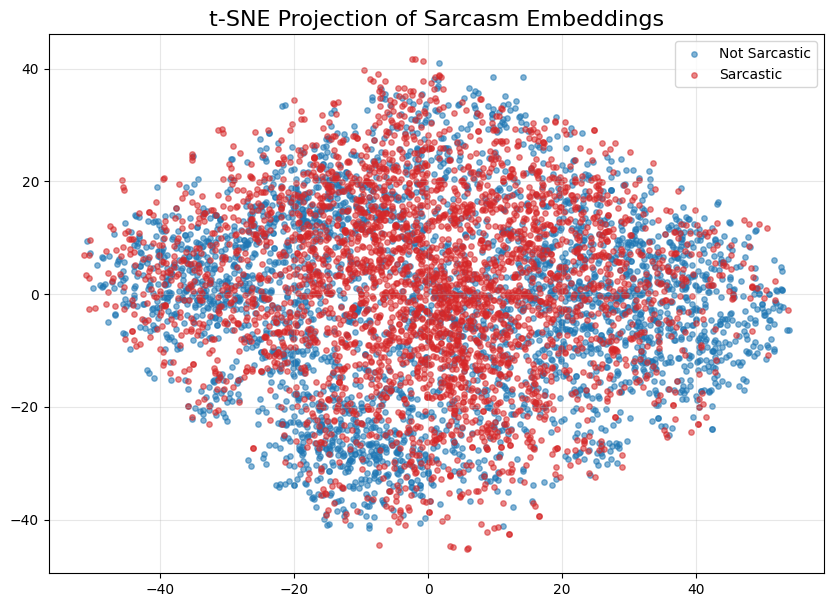

Done!


In [88]:
def plot_2d(data_2d, title):
    plt.figure(figsize=(10, 7))
    for class_value in [0, 1]:
        idx = labels == class_value
        plt.scatter(
            data_2d[idx, 0],
            data_2d[idx, 1],
            c=colors[class_value],
            alpha=0.55,
            label=label_names[class_value],
            s=15,
        )
    plt.title(title, fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print("Running t-SNE... (this may take a while)")
tsne = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate=200,
    n_iter_without_progress=1000,
    metric='cosine',
    random_state=42,
    verbose=1
)
tsne_reduced = tsne.fit_transform(emb)

plot_2d(tsne_reduced, "t-SNE Projection of Sarcasm Embeddings")

print("Done!")

True